# Research notes

### General notes

* Two regimes in time: annealing, and then settled
* Two regimes in setup: Egalitarian (Free knowledge) and dictator (Centralized knowledge)

---
### Model modification ideas

#### ⬛ **Major idea 1:** Groups have many dimensions

* Groups have the same number of preference dimensions as individuals
* Groups have fewer dimensions than individuals
 * Individuals need to balance their fulfillment with groups? How do they choose?
  * **Choice rule 1:** Individuals focus on the dimension which is furthest from any existing group ("I join this group to fulfill something I can't fulfill alone")
  * **Choice rule 2:** Individuals join multiple groups until all their dimensions are met
* Groups have more dimensions than individuals??
 * The groups' identity changes as the members who make it up change
 * Absent any within-group dynamics, why would this be any different than having separate groups?

#### ⬛ **Major idea 2:** Multiple group membership

* Individuals must join X groups, where X > 1
* Individuals join as many groups as fulfills them. This may need to involve some counterbalancing mechanic where individuals suffer a penalty for joining too many groups
 * Fulfillment : closest for each dimension
 * Fulfillment : closets for important dimensions

#### ⬛ **Major idea 3:** Groups splitting and joining

Easier goal would be to set up the rules explicitly and see how individual choices affects group ecology. 

* Encoding rules for groups splitting and fusing explicitly
  * Splitting because of size (i.e. group > 300 so it splits)
  * Splitting because of difference? (i.e. group's distribution has two modes, so it splits)
  * Splitting because of an optimization parameter (i.e. if a subset of the group would have decreased dissimilarity, it splits)

Harder goal would be to set up rules such that groups split and join dynamically. 

* Create set of rules that defines the substance/scope of group identity, and less about parsing out "least bad alternatives"

#### ⬛ **Major idea 4:** Bounded confidence

* Bounded confidence? Overlapping latitudes of acceptance/rejection? Ideas from discussion with Harry, terms from Jiin
 * Various inspirations from polarization psych analogous to network stuff

---

#### Other ideas

* Pure random model
* Let group hold its value before dying, from Jordan and Ismael. 
 * PROS: Gets at a sense of 'history'
 * CONS: It may not contribute to novel community growth?
* Heterogeneous accessibility / central media
 * Try to replicate the crash-and-burn dynamics of a central group actor
* Individuals are in a network (what would this mean?), or groups are in a network (what would this mean?)
* Mean voting for groups. Other mechanics/functions for group's preference value
* Circular preference dimension
* Write out the abstract/mathy form of this model. Function for choice, function for group aggregation of value 

### Model checks

* Test if it matters that individual values are discrete or continuous. Int vs float

#### Tossed

* Initialize with "closest group", from Sabina. Now with the model fixed, this will likely just be immediately stable. (DONE)

-----

### General dataset comparison ideas

* Crash-and-burn dynamics of platform chasing
* Within-person group changing dynamics
* Catching an ‘invisible exodus’ of people from one subreddit, and checking if they move to another subreddit? If the other sub survives?


### Specific dataset comparison ideas

* Take the times between group-switching for a particular person. Compare them to the times between subreddit-switching posting for a particular person? (Here posts==time)

--- 

# Setup functions

This should try its best to separate the following:
* Editing individual's relationships to groups
* Groups updating their values
* Any effects on public information



Class-version where you extend the graph class to include the individual function and group function. Good for instantiating many versions of the simulation. 

## Universal Functions

In [1]:
import networkx as nx
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import time
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
import functools
from copy import deepcopy
import scipy.stats as stats
import itertools
import warnings

In [2]:
def doNothing(self, public_info): #For debugging purposes when a function needs to be passed in
  pass

clamp = lambda n, minn, maxn: max(min(maxn, n), minn)

def calculateMean(netw, groupname, s=1): 
  groupneighs = list(netw.neighbors(groupname))
  thismean = None
  if len(groupneighs)>0:
    thismean = np.mean( np.vstack( [netw.nodes[eachnode]['valence'] for eachnode in groupneighs] ), axis=0) #Stack the RGB valences and take the mean
  else:
    print('%s has no members'%groupname)
  return thismean

def grabMeans(netw,grouplist):
  return {i: netw.nodes[i]['mean'] for i in grouplist}

def grabGroupsize(netw,grouplist):
  return {group: len(list(netw.neighbors(group))) for group in grouplist}

# def grabDifferenceStats(netw,grouplist):
#   meanvaldiff
#   meanvalvarr

#   for group in grouplist:
#     list(netw.neighbors(group))

def distMatrix1D(m): #Coded this up quickly because I'm too lazy to import scipy
  m = np.array(m)
  dist = np.tile(m,(len(m),1))
  return np.abs(dist - dist.T)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

Next, I want to implement a tracker to keep track of the following:

* Mean difference between indiv and group valence (as a mean of that difference, per group, over time)
* Variance of differences between indiv and group valence (as calculated from the distribution of valences, per group, over time)

In [3]:
class GroupshiftSim():
    
#===============================================================================
# Intializing
#===============================================================================

  def __init__(self, groupshift_function, indivchoice_function, groupFargs = {}, indivFargs = {}, lowvalence = 0, highvalence =100, s = 1, inittype='random', save_timesteps = []):
    self.lowvalence = lowvalence
    self.highvalence = highvalence
    self.s = s
    self.groupShift = groupshift_function
    self.indivChoice = indivchoice_function
    if inittype not in ['random', 'sorted']:
      raise Exception("Invalid type of graph connectivity initialization for this groupshift simulation.")

    #Statistics savers
    self.saved_graphs = {}
    self.savemeans = []
    self.savesizes = []
    #Group dists vs group sizes
#    self.savegroupdists_gdvgs = []
#    self.savegroupswaps_gdvgs = []
    #Robmetric
    self.savegroupdists_rmc = []
    self.savegroupdeltas_rmc = []
    #Robmetric simple
    self.savegroup_delGx = []
    self.savegroup_delGy = []
    self.save_timesteps = [0] + save_timesteps

    #Other arguments
    self.groupFargs = groupFargs
    self.indivFargs = indivFargs

  def initializeNodes(self, num_nodes, num_groups, initdist): 
    self.num_nodes = num_nodes
    self.num_groups = num_groups
    self.grouplist = ['Group%i'%i for i in range(num_groups)]
    self.nodelist = list(range(num_nodes))
    
    #Creating graph
    self.g = nx.Graph()
    if initdist == 'random':
      nodes_with_valence = [(i,{'valence':np.random.randint(self.lowvalence,self.highvalence, size=self.s)}) for i in self.nodelist]
      self.g.add_nodes_from( nodes_with_valence )   #Add nodes with attribute 'valence': (R,G,B)
      self.g.add_nodes_from( self.grouplist ) #Add grouplist nodes WITHOUT THEIR MEANS
      self.g.add_edges_from( [(i,np.random.choice(self.grouplist)) for i in self.nodelist] )  #Add edges randomly between nodes and grouplist nodes
    elif initdist == 'normal':
      nodes_with_valence = [(i, {'valence': np.clip(np.random.normal((self.highvalence-self.lowvalence)/2, 15, size=self.s),self.lowvalence,self.highvalence) }) for i in self.nodelist] 
        #Manually input the stdev because it's easier to set that than calculate it
        #Clamped it to [lowvalence,highvalence] just in case
      self.g.add_nodes_from( nodes_with_valence )   #Add nodes with attribute 'valence': (R,G,B)
      self.g.add_nodes_from( self.grouplist ) #Add grouplist nodes WITHOUT THEIR MEANS
      self.g.add_edges_from( [(i,np.random.choice(self.grouplist)) for i in self.nodelist] )  #Add edges randomly between nodes and grouplist nodes
    elif initdist == 'sorted':
      self.g.add_nodes_from( self.grouplist )
      self.g.add_nodes_from( self.nodelist )
      edgelist = [(i,np.random.choice(self.grouplist)) for i in self.nodelist]
      self.g.add_edges_from( edgelist )
      #Sort the edges
      sorted_nodes, sorted_groups = zip(*sorted(edgelist, key=lambda kv:(kv[1], kv[0])))
      #Add in values sorted, and map it to the sorted edges
      sorted_valences = sorted( [np.random.randint(self.lowvalence,self.highvalence, size=self.s) for i in range(self.num_nodes)] )
      valence_dict = {sorted_nodes[i]: sorted_valences[i] for i in range(len(sorted_nodes)) }
      nx.set_node_attributes(self.g, valence_dict, 'valence')
    
#===============================================================================
# Running simulations, saving data
#===============================================================================

  def runSimulation(self, timesteps):
    self.timesteps = timesteps
    self.save_timesteps.append(timesteps-1) #Automatically save the last timestep

    #Transform arguments in kwargs into arrays if they are not already arrays
    for k in self.groupFargs.keys():
      #If the argument is not an array...
      if type(self.groupFargs[k]) != list:
        self.groupFargs[k] = [self.groupFargs[k] for i in range(timesteps)] #...turn it into an array (I did not do this by multiplying because I don't want the entire thing to copy a referent)
      #If the argument is an array...
      elif (type(self.groupFargs[k])) == list:
        #Warning if the array mismatches the number of timesteps
        if len(self.groupFargs[k]) != timesteps:
          warnings.warn("\nWarning: The variable " + str(k) + " in the group function's arguments is an array of the wrong size. Expected length of " + str(timesteps) + 
                        " but received " + str(len(self.groupFargs[k])) + ". \nReminder! Arrays too short will sustain the final value; values beyond the number of timesteps will be ignored.")
          #If the list is too short...
          if len(self.groupFargs[k]) < timesteps:
            #...repeat the final value until it matches the number of timesteps
            self.groupFargs[k] += [self.groupFargs[k][-1]] * (timesteps - len(self.groupFargs[k]))

    for t in tqdm(range(self.timesteps)):
      #Save out the graph data
      if t in self.save_timesteps:
        self.saved_graphs[t] = deepcopy(self.g)

      #Pick out this timestep's parameters for the group and individual functions
      these_groupFargs = {k: self.groupFargs[k][t] for k in self.groupFargs.keys()}
      these_indivFargs = {k: self.indivFargs[k][t] for k in self.indivFargs.keys()}

      #Perform group shift function
      self.groupShift(self, **these_groupFargs)

      #Save out the statistical data
      self.savebasics()

      #self.groupdistVgroupswap()
      self.robMetric()
      self.robMetricSimple()

      #Perform node selection step function
      public_information = grabMeans(self.g,self.grouplist)
      self.indivChoice(self, public_information, **these_indivFargs) #How to parameterize? 

#===============================================================================
# Calculate statistics
#===============================================================================

  def savebasics(self):
      thesemeans = deepcopy(grabMeans(self.g,self.grouplist))
      thesesizes = deepcopy(grabGroupsize(self.g,self.grouplist))
      self.savemeans.append(thesemeans)
      self.savesizes.append(thesesizes)

  # def groupdistVgroupswap(self): #Metric code gdvds
  #   #Save numbers for the [distance between group A and B], and the [proportion of people who would prefer to be in the other group]
  #   groupmeans_dict = deepcopy(grabMeans(self.g,self.grouplist))
  #   num_groups = len(groupmeans_dict)
  #   groupmeans_flat = [groupmeans_dict['Group%i'%i] for i in range(num_groups)] #Assumes that the groups are ordered from Group1-10
  #   groupdists = distMatrix1D(groupmeans_flat)

  #   groupswaps = np.zeros((num_groups,num_groups))
  #   for i,j in itertools.combinations(range(num_groups),2): #For every pair of group
  #     groupA = 'Group%i'%i
  #     groupB = 'Group%i'%j
  #     groupA_val = self.g.nodes[groupA]['mean']
  #     groupB_val = self.g.nodes[groupB]['mean']
  #     #Calculate proportion of people in optimal position vs suboptimal
  #     group_stay = set([])
  #     group_switch = set([])
  #     ppl_groupA = set(self.g.neighbors(groupA))
  #     ppl_groupB = set(self.g.neighbors(groupB))
  #     for person in ppl_groupA:
  #       #If distance to own group is greater...
  #       if np.abs(groupA_val - self.g.nodes[person]['valence']) > np.abs(groupB_val - self.g.nodes[person]['valence']): #This assumes 1d valence
  #         group_switch.add(person)
  #       else:
  #         group_stay.add(person)
  #     for person in ppl_groupB:
  #       if np.abs(groupB_val - self.g.nodes[person]['valence']) > np.abs(groupA_val - self.g.nodes[person]['valence']): #This assumes 1d valence
  #         group_switch.add(person)
  #       else:
  #         group_stay.add(person)
  #     value = float(len(group_switch)) / (len(group_stay)+len(group_switch))
  #     groupswaps[i,j] = value
  #     groupswaps[j,i] = value

  #   self.savegroupdists_gdvgs.append(groupdists)
  #   self.savegroupswaps_gdvgs.append(groupswaps)

  def robMetric(self): #Metric code rmc
    #Calculate mean of G minus G (mu(G) - G) for group1 and group 2
    #Call this delG_1 = (mu(G_1) - G_1)
    #Plot that as...signed difference of G_1 - G_2 VERSUS delG_1 - delG_2
    groupdists_signed = np.zeros((self.num_groups,self.num_groups))
    groupdeltas = np.zeros((num_groups,num_groups))

    for i,j in itertools.combinations(range(num_groups),2): #For every pair of group
      group1 = 'Group%i'%i
      group2 = 'Group%i'%j
      groupdists_signed[i,j] = self.g.nodes[group2]['mean'] - self.g.nodes[group1]['mean']
      groupdists_signed[j,i] = self.g.nodes[group1]['mean'] - self.g.nodes[group2]['mean']
      if len(list(self.g.neighbors(group1))) > 0 and len(list(self.g.neighbors(group2))) > 0:
        mu_1 = calculateMean(self.g, group1)
        mu_2 = calculateMean(self.g, group2)
        #The following effect is signed, so the value is different depending on direction
        groupdeltas[i,j] = (mu_2 - self.g.nodes[group2]['mean']) - (mu_1 - self.g.nodes[group1]['mean'])
        groupdeltas[j,i] = (mu_1 - self.g.nodes[group1]['mean']) - (mu_2 - self.g.nodes[group2]['mean'])
      else:                                                                                             #<--WHAT SHOULD THE VALUE BE IF ONE OF THE GROUPS DOESN'T HAVE MEMBERS?
        groupdeltas[i,j] = -10
        groupdeltas[j,i] = -10
      
    self.savegroupdists_rmc.append(groupdists_signed)
    self.savegroupdeltas_rmc.append(groupdeltas)

  def robMetricSimple(self):
    #Calculate delG_1 on its own
    #Plot this against the value of G

    delGs = {}
    for group in self.grouplist:
      if len(list(self.g.neighbors(group))) > 0:
        mu = calculateMean(self.g, group)
        delG = mu - self.g.nodes[group]['mean']
        delGs[group] = delG
      else:                                                                                            #<--WHAT SHOULD THE VALUE BE IF ONE OF THE GROUPS DOESN'T HAVE MEMBERS?
        delGs[group] = -10
    
    self.savegroup_delGx.append( grabMeans(self.g,self.grouplist) )
    self.savegroup_delGy.append( delGs )
  
  def howManyUnsorted(self):
    #Calculate how many people are not in their optimal group
    pass

#===============================================================================
# Plotting functions
#===============================================================================

  def plotTimelineMeans(self, legend=True):
    #Grabbing and plotting means over time
    meansdata = {i:[] for i in self.grouplist}
    for m in self.savemeans:
      for group in self.grouplist:
        meansdata[group].append(m[group])

    plt.figure(figsize=(15,10))
    for group in self.grouplist:
      thisthing = np.array(meansdata[group]).T
      plt.plot(thisthing[0], linewidth=1, label=group)

    plt.title("Group means over time, 1D")
    plt.xlabel("Time (t)")
    plt.ylabel("Mean valence")
    plt.ylim((self.lowvalence,self.highvalence))
    #plt.ylim(self.lowvalence,self.highvalence)
    if legend: 
      plt.legend()
    plt.show()

  #-----------------------------------------------------------------------------
  def plotTimelineSizes(self, legend=True):
    #Constructing a tidy dataframe
    to_dataframe = {'group': [], 'timestep': [], 'size': []}
    for i, m in enumerate(self.savesizes):
      for group in self.grouplist:
        to_dataframe['group'].append(group)
        to_dataframe['timestep'].append(i)
        to_dataframe['size'].append(m[group])
      
    modeldf = pd.DataFrame(to_dataframe)
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.lineplot(x='timestep', y='size', hue='group', data = modeldf, linewidth=1, legend=legend).set(title="Group sizes over time")
    plt.show()


  #------------------
  def plotIndivDist(self, t='now', overall = True, legend=True):
    if t=='now':
      thisgraph = self.g
    elif type(t) == int:
      if t not in self.saved_graphs:
        raise Exception("The graph at the timestep you requested has not been saved. This timestep is not available.")
      thisgraph = self.saved_graphs[t]      
    else: 
      raise Exception("Invalid input for timeslice parameter for plotting the distribution of individual values.")

    agent_valences = nx.get_node_attributes(thisgraph,'valence')
    agent_sets = {xx:list(thisgraph.neighbors(xx)) for xx in self.grouplist} #Grab the agents associated with each group
    agent_sets_valence = {xx:[agent_valences[i][0] for i in agent_sets[xx]] for xx in self.grouplist} #Grab the valence associated with each agent, by group


    if overall:
      agent_valences_squish = [x[0] for x in agent_valences.values()]
      sns.set(rc={'figure.figsize':(11.7,8.27)})
      sns.displot(agent_valences_squish, bins=15, kde=True).set(title='Distributions of agent opinions, all')
      plt.xlabel('Valence')
      plt.ylabel('Num agents')
    else: 
      data_to_plot = [agent_sets_valence[xx] for xx in self.grouplist]
      sns.displot(data_to_plot, kind='kde', legend=legend).set(title="Distributions of agent opinions by group")

  #-----------------------------------------------------------------------------
  def plotDistSwap(self, legend=True, timespan = [], ylimits=[], scattersize = 1):
    if len(timespan)==2 and type(timespan[0]) is int and type(timespan[1]) is int:
      starttime = max(0,timespan[0])
      endtime = min(self.timesteps,timespan[1]) if timespan[1]<self.timesteps else self.timesteps
    else:
      starttime = 0
      endtime = self.timesteps
    print("Plotting timespan from %i to %i..."%(starttime, endtime))

    #Extracting info on group swaps
    #THIS NEEDS TO BE CHECKED IF IT'S PLOTTING VALUES BOTH ABOVE AND BELOW THE DIAGONAL
    for i in range(self.num_groups):
      for j in range(self.num_groups):
        x = [self.savegroupdists_gdvgs[t][i,j] for t in range(starttime, endtime)]
        y = [self.savegroupswaps_gdvgs[t][i,j] for t in range(starttime, endtime)]
        plt.plot(x,y, label='%i to %i'%(i,j), linewidth=1)

    plt.xlabel("Distance between Group A and Group B")
    plt.ylabel("Percent of people who prefer to switch")
    plt.xlim([0,100])
    if ylimits!=[]:
      plt.ylim(ylimits)
    plt.show()

  #-----------------------------------------------------------------------------
  def plotRMC(self, legend=False, timespan = [], ylimits=[], scattersize = 1, individual_plots=False): #Plots for rob's metric
    if len(timespan)==2 and type(timespan[0]) is int and type(timespan[1]) is int:
      starttime = max(0,timespan[0])
      endtime = min(self.timesteps,timespan[1]) if timespan[1]<self.timesteps else self.timesteps
    else:
      starttime = 0
      endtime = self.timesteps
    print("Plotting timespan from %i to %i..."%(starttime, endtime))

    #THIS CODE NEEDS TO BE CHECKED FOR HOW IT'S PLOTTING VALUES. IS THE ABOVE/BELOW DIAGONAL IMPORTANT?
    for i in range(self.num_groups):
      for j in range(self.num_groups):
        x = [self.savegroupdists_rmc[t][i,j] for t in range(starttime, endtime)]
        y = [self.savegroupdeltas_rmc[t][i,j] for t in range(starttime, endtime)]
        plt.plot(x,y, label='%i to %i'%(i,j), linewidth=1)
        if scattersize > 1:
          plt.scatter(x,y,s=scattersize)
        else:
          plt.plot(x,y, label='%i to %i'%(i,j), linewidth=1)
      if individual_plots:
        plt.xlabel("Distance between Group %i and other groups"%(i))
        plt.ylabel("Discrepancy between constituents for Group %i and other groups"%(i))
        plt.xlim([-100,100])
        if ylimits!=[]:
          plt.ylim(ylimits)
        plt.show()

    if not individual_plots:
      plt.xlabel("Distance between Group A and Group B")
      plt.ylabel("Discrepancy between constituents for Groups A and Group B")
      plt.xlim([-100,100])
      if ylimits!=[]:
        plt.ylim(ylimits)
      plt.show()

  #-----------------------------------------------------------------------------
  def plotRMCsimple(self, legend=False, timespan = [], ylimits=[], scattersize = 1):
    if len(timespan)==2 and type(timespan[0]) is int and type(timespan[1]) is int:
      starttime = max(0,timespan[0])
      endtime = min(self.timesteps,timespan[1]) if timespan[1]<self.timesteps else self.timesteps
    else:
      starttime = 0
      endtime = self.timesteps
    print("Plotting timespan from %i to %i..."%(starttime, endtime))

    #Take out values for each
    for group in self.grouplist:
      x = [self.savegroup_delGx[t][group] for t in range(starttime, endtime)]
      y = [self.savegroup_delGy[t][group] for t in range(starttime, endtime)]
      plt.plot(x,y, label=group)
      if scattersize > 1:
        plt.scatter(x,y, s=scattersize)
    
    plt.xlabel("Group's value")
    plt.ylabel("Discrepancy between group and members")
    plt.xlim([0,100])
    if ylimits!=[]:
      plt.ylim(ylimits)

    plt.show()

## Common functions

Certain functions, like groups calculating their means, will occur across multiple models, but they aren't necessarily universal functions in that they are technically parameters of the model. 

In [4]:
#This function edits a graph in place
def recalcMean(self, netw, groupname, resettype='sust', s=1):
  groupneighs = list(netw.neighbors(groupname))
  if len(groupneighs)>0:
    thismean = np.mean( np.vstack( [netw.nodes[eachnode]['valence'] for eachnode in groupneighs] ), axis=0) #Stack the RGB valences and take the mean
    netw.nodes[groupname]['mean'] = thismean
  else:
    #Set default to zero. This may cause the homogenization
    if resettype == 'zero':
      netw.nodes[groupname]['mean'] = np.zeros(s)
    elif resettype == 'rand':
      #Set default to random. 
      netw.nodes[groupname]['mean'] = np.random.randint(self.lowvalence,self.highvalence,size=s)
    elif resettype == 'sust':
      pass #Do nothing and let the mean be the same as it was

def groupshiftSimpleMean(self, resettype='sust', s=1):
  for i in self.grouplist: 
    recalcMean(self, self.g, i, resettype=resettype, s=s)

def oneNodeOpenSwitch(self, public_info):
  #Randomly select a node
  thisnode = np.random.choice(self.nodelist)

  #Calculate distances (for colors)
  dists = {}
  for i in public_info:
    dists[i] = np.linalg.norm(public_info[i] - self.g.nodes[thisnode]['valence'])
  #Get the group with the minimum distance
  mingroup = min(dists,key=dists.get)
  #Replace current group edge
  currentgroup = list(self.g.neighbors(thisnode))[0]
  if currentgroup != mingroup:
    self.g.remove_edge(thisnode,currentgroup)
    self.g.add_edge(thisnode,mingroup)


################################################################################
#     REPULSION AND ATTRACTION FUNCTIONS
################################################################################

def groupshiftRepulseAttract(self, rWidth, rAmp, aWidth, aAmp, resettype='sust', s=1):
  gsRepulse(self, rWidth, rAmp, resettype=resettype, s=s)
  gsAttract(self, aWidth, aAmp, resettype=resettype, s=s)

def gsRepulse(self, rWidth, rAmp, resettype, s):
  width = rWidth    #Increases the range of the repulsion effect
    #width will determine the baseline differe
    #width = 1 results in a gradual slow curve with pretty even spread over 10k timesteps
    #width = 100 results in a ~30 value difference between groups fairly quickly
  amp = rAmp      #Increases the amount of pushback that the repulsion effect causes

  if 'mean' not in self.g.nodes['Group0']:
    for i in self.grouplist: 
      recalcMean(self, self.g, i, resettype=resettype, s=s)
  #Group repulsion
  #Grab the group means
  groupmeans_dict = nx.get_node_attributes(self.g,'mean') #Get the valences
  groupmeans = [groupmeans_dict[i][0] for i in self.grouplist] #Make sure they're ordered and in list form
  
  #Calculate distances
  dmatrix = []
  signed_dmatrix = []
  for i in groupmeans:
    dmatrix.append( np.abs(i - np.array(groupmeans)))
    signed_dmatrix.append( i - np.array(groupmeans))
  dmatrix = np.array(dmatrix)
  signed_dmatrix = np.array(signed_dmatrix)

  #Calculate e^(-|A-B|), then multiply it by the sign of the distance value
  update_vals = np.exp(-1 * (1/width) * dmatrix**2)
  update_vals = update_vals * np.sign(signed_dmatrix) * amp

  #Sum up the forces across all of the other points that will affect this point
  update_vals = np.sum(update_vals, axis=1)
  #Update the groups' values 
  update_vals_d = dict(zip(self.grouplist, update_vals))
  for group in self.grouplist:
    newval = self.g.nodes[group]['mean'][0] + update_vals_d[group]
    #Clamp the group value
    newval = min(max(newval, self.lowvalence),self.highvalence)
    self.g.nodes[group]['mean'] = np.array([newval]) #This needs to be an array of length d                   #POTENTIAL DIMENSIONAL ISSUE


def gsAttract(self, aWidth, aAmp, resettype, s):
  width = aWidth
  #A higher width is necessary, because the attraction function with width=1 is more like a point attraction, and groups will get 'stuck' on their nearest member
  amp = aAmp
  #Amplitude more effects the 'step size' that a group will take. A higher value can cause oscillations because the group can't move gradually enough

  if 'mean' not in self.g.nodes['Group0']:
    for i in self.grouplist: 
      recalcMean(self, self.g, i, resettype=resettype, s=s)

  #Grab the group means
  groupmeans_dict = nx.get_node_attributes(self.g,'mean') #Get the means

  for groupname in groupmeans_dict:  
    #Grab the node valences
    groupneighs = list(self.g.neighbors(groupname))
    membervalences = [self.g.nodes[i]['valence'][0] for i in groupneighs]                                      #DIM REDUCTION

    #Calculate the distances
    op = deepcopy(groupmeans_dict[groupname])[0]                                                              #DIM REDUCTION
    for i in membervalences:
      pointing = 1 if groupmeans_dict[groupname][0] < i else -1
      #Update `op` based on the relative positions of the group and the individual
      op += pointing * amp * np.exp(-1*(1/width) * ( np.abs(groupmeans_dict[groupname][0]-i))**2 ) * (1/len(groupneighs))
    
    op = min(max(op, self.lowvalence),self.highvalence)
    self.g.nodes[groupname]['mean'] = np.array([op])                                                           #DIM RESTORATION

# Running

## Model 1 Baseline

In [ ]:
testSimBasic = GroupshiftSim(groupshift_function = groupshiftSimpleMean,
                        indivchoice_function = oneNodeOpenSwitch,
                        inittype='sorted',
                        save_timesteps=list(range(0,10000,1000)))

num_nodes = 1000
num_groups = 10
timesteps = 15000

testSimBasic.initializeNodes(num_nodes, num_groups, 'random')
testSimBasic.runSimulation(timesteps)

100%|██████████| 15000/15000 [06:45<00:00, 37.00it/s]


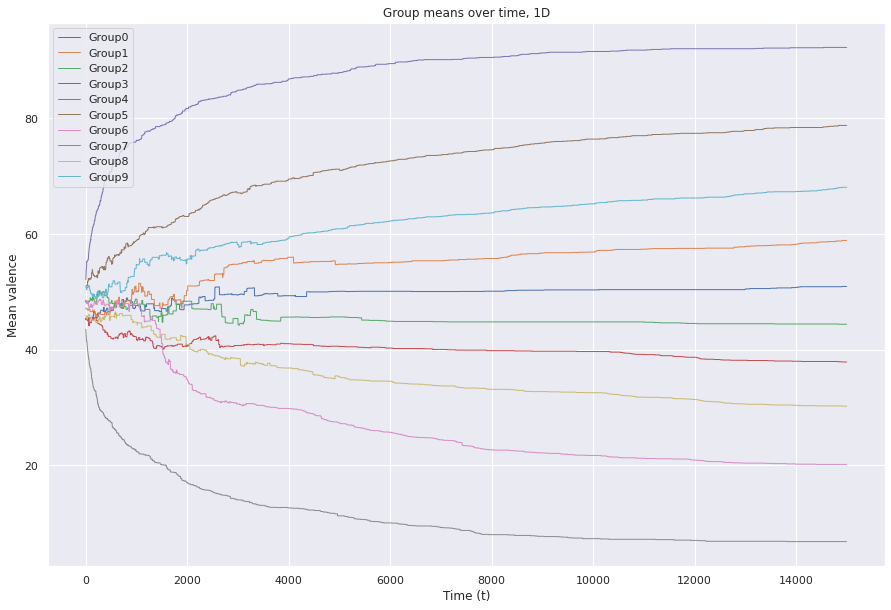

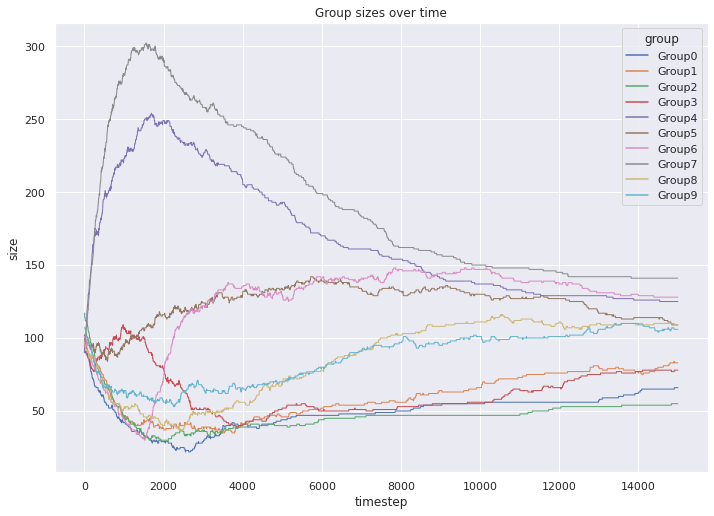

In [ ]:
testSimBasic.plotTimelineMeans()
testSimBasic.plotTimelineSizes()

Plotting timespan from 0 to 15000...


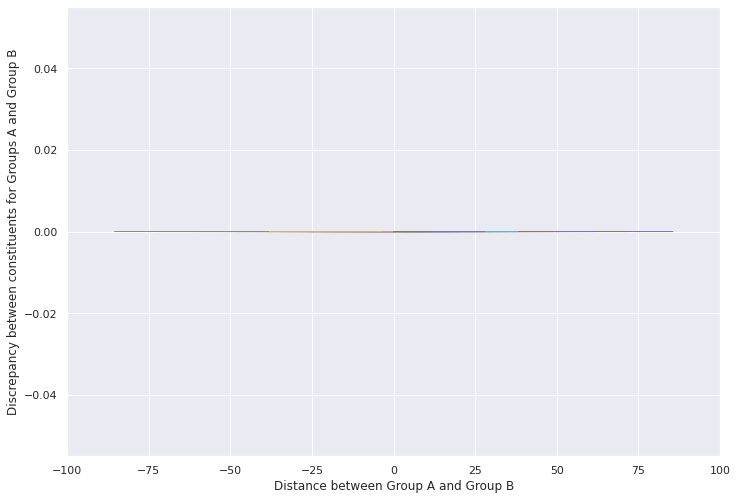

Plotting timespan from 0 to 15000...


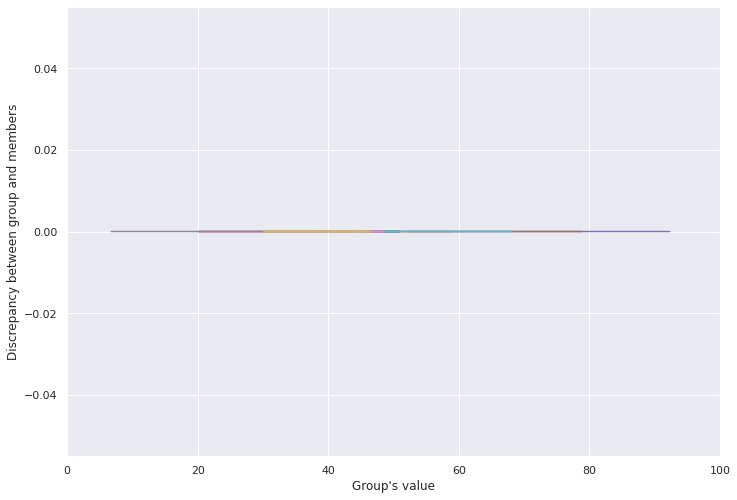

In [ ]:
testSimBasic.plotRMC(legend=False, timespan = [])
testSimBasic.plotRMCsimple(legend=False, timespan = [])

## Model 2 Including error

Inherited from model 1, but agent slightly changes randomly at each change. 

In [ ]:
def oneNodeOpenSwitchWithError(self, public_info, kwargs):
  #Randomly select a node
  thisnode = np.random.choice(self.nodelist)

  #Calculate distances (for colors)
  dists = {}
  for i in public_info:
    dists[i] = np.linalg.norm(public_info[i] - self.g.nodes[thisnode]['valence'])
  #Get the group with the minimum distance
  mingroup = min(dists,key=dists.get)
  #Replace current group edge
  currentgroup = list(self.g.neighbors(thisnode))[0]
  if currentgroup != mingroup:
    self.g.remove_edge(thisnode,currentgroup)
    self.g.add_edge(thisnode,mingroup)
  
  #Add randomly noise to agent's value
  self.g.nodes[thisnode]['valence'] = [clamp(np.random.normal(self.g.nodes[thisnode]['valence'][x],kwargs['e']),self.lowvalence,self.highvalence) for x in range(self.s)]

In [ ]:
testSim = GroupshiftSim(groupshift_function = groupshiftSimpleMean,
                        indivchoice_function = oneNodeOpenSwitchWithError)

num_nodes = 1000
num_groups = 10
timesteps = 10000

testSim.initializeNodes(num_nodes, num_groups, 'random')
testSim.runSimulation(timesteps, e=100) 
# I don't know why, but e has to be pretty big in order for there to be an effect on the groups. 

In [ ]:
testSim.plotTimelineMeans()
testSim.plotTimelineSizes()

## Model 3 Latitude of acceptability

Limiting individual's capacity to choose groups based on their current group

In [ ]:
def model3(num_nodes,num_groups,timesteps, k,plots=False,resettype='zero', s=1):
  grouplist = ['Group%i'%i for i in range(num_groups)]
  #Creating graph
  g = nx.Graph()
  g.add_nodes_from( [(i,{'valence':np.random.randint(0,255,size=s)}) for i in range(num_nodes)] )   #Add nodes with attribute 'valence': (R,G,B)
  g.add_nodes_from( grouplist ) #Add grouplist nodes
  g.add_edges_from( [(i,np.random.choice(grouplist)) for i in range(num_nodes)] )  #Add edges randomly between nodes and grouplist nodes

  #Plot before-and-after, if desired
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()

  savemeans = []
  savesizes = []

  for t in tqdm(range(timesteps)):
    #Recalculate the means
    for i in grouplist:
      meanRecalc(g,i,resettype,s=s)
    #Randomly select a node
    thisnode = np.random.choice(range(num_nodes))

    #Grab statistics
    thesemeans = grabMeans(g,grouplist)
    thesesizes = grabGroupsize(g,grouplist)
    savemeans.append(thesemeans)
    savesizes.append(thesesizes)

    #Calculate distances between each group
    currentgroup = list(g.neighbors(thisnode))[0]
    #Get the k nearest groups
    gdists = {}
    for i in thesemeans:
      gdists[i] = np.linalg.norm(thesemeans[i] - g.nodes[currentgroup]['mean'])
    #Get the groupS (MULTIPLE!) within the latitude of acceptability
    mingroups = sorted(gdists, key=gdists.get)[0:k]

    #Calculate distances against the individual
    dists = {}
    for i in mingroups:
      dists[i] = np.linalg.norm(thesemeans[i] - g.nodes[thisnode]['valence'])
    #Get the group with the minimum distance
    mingroup = min(dists,key=dists.get)
    #Replace current group edge
    if currentgroup != mingroup:
      g.remove_edge(thisnode,currentgroup)
      g.add_edge(thisnode,mingroup)
    
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()
  
  otherdata = {'means': savemeans, 'sizes': savesizes}
  
  return g, otherdata

## Model 4 Simple dictator

In [ ]:
def model4(num_nodes,num_groups,timesteps,plots=False,resettype='zero', s=1):
  grouplist = ['Group%i'%i for i in range(num_groups)]
  #Creating graph
  g = nx.Graph()
  g.add_nodes_from( [(i,{'valence':np.random.randint(0,255,size=s)}) for i in range(num_nodes)] )   #Add nodes with attribute 'valence': (R,G,B)
  g.add_nodes_from( grouplist ) #Add grouplist nodes
  g.add_edges_from( [(i,np.random.choice(grouplist)) for i in range(num_nodes)] )  #Add edges randomly between nodes and grouplist nodes

  #Plot before-and-after, if desired
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()

  savemeans = []
  savesizes = []

  for t in tqdm(range(timesteps)):
    #Recalculate the means
    for i in grouplist:
      meanRecalc(g,i,resettype,s=s)
    #Randomly select a node
    thisnode = np.random.choice(range(num_nodes))

    #Grab statistics
    thesemeans = grabMeans(g,grouplist)
    thesesizes = grabGroupsize(g,grouplist)
    savemeans.append(thesemeans)
    savesizes.append(thesesizes)

    #Calculate distances (for colors)
    dists = {}
    for i in thesemeans:
      dists[i] = np.linalg.norm(thesemeans[i] - g.nodes[0]['valence']) #Calculated against the preference of a single node
    #Get the group with the minimum distance
    mingroup = min(dists,key=dists.get)
    #Replace current group edge
    currentgroup = list(g.neighbors(thisnode))[0]
    if currentgroup != mingroup:
      g.remove_edge(thisnode,currentgroup)
      g.add_edge(thisnode,mingroup)
    
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()
  
  otherdata = {'means': savemeans, 'sizes': savesizes}
  
  return g, otherdata

## Model 5 Modifier: Central Media

In [ ]:
def model5(num_nodes,num_groups,timesteps,plots=False,resettype='zero', s=1):
  grouplist = ['Group%i'%i for i in range(num_groups)]
  #Creating graph
  g = nx.Graph()
  g.add_nodes_from( [(i,{'valence':np.random.randint(0,255,size=s)}) for i in range(num_nodes)] )   #Add nodes with attribute 'valence': (R,G,B)
  g.add_nodes_from( grouplist ) #Add grouplist nodes
  g.add_edges_from( [(i,np.random.choice(grouplist)) for i in range(num_nodes)] )  #Add edges randomly between nodes and grouplist nodes

  #Plot before-and-after, if desired
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()

  savemeans = []
  savesizes = []

  for t in tqdm(range(timesteps)):
    #Recalculate the means
    for i in grouplist:
      meanRecalc(g,i,resettype,s=s)
    #Randomly select a node
    thisnode = np.random.choice(range(num_nodes))

    #Grab statistics
    thesemeans = grabMeans(g,grouplist)
    thesesizes = grabGroupsize(g,grouplist)
    savemeans.append(thesemeans)
    savesizes.append(thesesizes)

    #Calculate distances (for colors)
    dists = {}
    for i in thesemeans:
      d = np.linalg.norm(thesemeans[i] - g.nodes[thisnode]['valence'])
      groupnum = int(''.join(map(lambda c: c if c in '0123456789' else '', i))) #Modify the distances
      dists[i] = d*(float(groupnum+1)/num_groups)
    #Get the group with the minimum distance
    mingroup = min(dists,key=dists.get)
    #Replace current group edge
    currentgroup = list(g.neighbors(thisnode))[0]
    if currentgroup != mingroup:
      g.remove_edge(thisnode,currentgroup)
      g.add_edge(thisnode,mingroup)
    
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()
  
  otherdata = {'means': savemeans, 'sizes': savesizes}
  
  return g, otherdata

## Model 6 Group dictator

In [ ]:
def model6(num_nodes,num_groups,timesteps,plots=False,resettype='zero', s=1):
  grouplist = ['Group%i'%i for i in range(num_groups)]
  #Creating graph
  g = nx.Graph()
  g.add_nodes_from( [(i,{'valence':np.random.randint(0,255,size=s)}) for i in range(num_nodes)] )   #Add nodes with attribute 'valence': (R,G,B)
  g.add_nodes_from( grouplist ) #Add grouplist nodes
  g.add_edges_from( [(i,np.random.choice(grouplist)) for i in range(num_nodes)] )  #Add edges randomly between nodes and grouplist nodes

  #Plot before-and-after, if desired
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()

  savemeans = []
  savesizes = []

  for t in tqdm(range(timesteps)):
    #Recalculate the means
    for i in grouplist:
      meanRecalc(g,i,resettype,s=s)
    #Randomly select a node
    thisnode = np.random.choice(range(num_nodes))

    #Grab statistics
    thesemeans = grabMeans(g,grouplist)
    thesesizes = grabGroupsize(g,grouplist)
    savemeans.append(thesemeans)
    savesizes.append(thesesizes)

    #Randomly select member of group 0
    dictatornode = np.random.choice( list(g.neighbors('Group0')) )
    #Calculate distances (for colors)
    dists = {}
    for i in thesemeans:
      dists[i] = np.linalg.norm(thesemeans[i] - g.nodes[dictatornode]['valence']) #Calculated against the preference of a single node
    #Get the group with the minimum distance
    mingroup = min(dists,key=dists.get)
    #Replace current group edge
    currentgroup = list(g.neighbors(thisnode))[0]
    if currentgroup != mingroup:
      g.remove_edge(thisnode,currentgroup)
      g.add_edge(thisnode,mingroup)
    
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()
  
  otherdata = {'means': savemeans, 'sizes': savesizes}
  
  return g, otherdata

## Model 7 Change rates 1

At every timestep, randomly update the opinion of a single agent. Change group update function to update by rate toward mean. 

In [ ]:
def meanAdjust(netw, groupname, rate, resettype, s=3):
  groupneighs = list(netw.neighbors(groupname))
  if len(groupneighs)>0:
    oldmean = netw.nodes[groupname]['mean']
    truemean = np.mean( np.vstack( [netw.nodes[eachnode]['valence'] for eachnode in groupneighs] ), axis=0) #Stack the RGB valences and take the mean
    if oldmean < truemean: 
      netw.nodes[groupname]['mean'] = oldmean + rate
    elif oldmean > truemean:
      netw.nodes[groupname]['mean'] = oldmean - rate
  else:
    #Set default to zero. This may cause the homogenization
    if resettype == 'zero':
      netw.nodes[groupname]['mean'] = np.zeros(s)
    elif resettype == 'rand':
      #Set default to random. 
      netw.nodes[groupname]['mean'] = np.random.randint(0,255,size=s)
    elif resettype == 'sust':
      pass #Do nothing and let the mean be the same as it was

In [ ]:
def model7(num_nodes,num_groups,timesteps,eta, theta, plots=False,resettype='zero', s=1):
  grouplist = ['Group%i'%i for i in range(num_groups)]
  #Creating graph
  g = nx.Graph()
  g.add_nodes_from( [(i,{'valence':np.random.randint(0,255,size=s)}) for i in range(num_nodes)] )   #Add nodes with attribute 'valence': (R,G,B)
  g.add_nodes_from( grouplist ) #Add grouplist nodes
  g.add_edges_from( [(i,np.random.choice(grouplist)) for i in range(num_nodes)] )  #Add edges randomly between nodes and grouplist nodes

  #Instantiate group means
  for i in grouplist:
    meanRecalc(g,i,resettype,s=s)

  #Plot before-and-after, if desired
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()

  savemeans = []
  savesizes = []

  for t in tqdm(range(timesteps)):
    #Recalculate the means
    for i in grouplist:
      meanAdjust(g,i,theta,resettype,s=s)
    #Randomly select a node
    thisnode = np.random.choice(range(num_nodes))

    #Grab statistics
    thesemeans = grabMeans(g,grouplist)
    thesesizes = grabGroupsize(g,grouplist)
    savemeans.append(thesemeans)
    savesizes.append(thesesizes)

    #Calculate distances (for colors)
    dists = {}
    for i in thesemeans:
      dists[i] = np.linalg.norm(thesemeans[i] - g.nodes[thisnode]['valence'])
    #Get the group with the minimum distance
    mingroup = min(dists,key=dists.get)
    #Replace current group edge
    currentgroup = list(g.neighbors(thisnode))[0]
    if currentgroup != mingroup:
      g.remove_edge(thisnode,currentgroup)
      g.add_edge(thisnode,mingroup)

    #Randomly update one agent's opinion
    shiftnode = np.random.choice(range(num_nodes))
    oldvalence = g.nodes[shiftnode]['valence']
    groupmean = g.nodes[list(g.neighbors(thisnode))[0]]['mean']
    if oldvalence < groupmean:
      g.nodes[shiftnode]['valence'] = oldvalence + eta
    elif oldvalence > groupmean:
      g.nodes[shiftnode]['valence'] = oldvalence - eta
    
  if plots==True:
    pos = nx.spring_layout(g)
    nx.draw(g,pos=pos,node_size=5)
    plt.show()
  
  otherdata = {'means': savemeans, 'sizes': savesizes}
  
  return g, otherdata

## Model 8 Simple suboptimal choices

In [ ]:
def oneNodeOpenSwitchSuboptimal(self, public_info, kwargs):
  #Randomly select a node
  thisnode = np.random.choice(self.nodelist)

  #Calculate distances (for colors)
  dists = {}
  for i in public_info:
    dists[i] = np.linalg.norm(public_info[i] - self.g.nodes[thisnode]['valence'])
  #Get the group with the minimum distance
  dist_order = sorted(dists,key=dists.get)
  #Replace current group edge
  currentgroup = list(self.g.neighbors(thisnode))[0]
  currentgroupindex = dist_order.index(currentgroup)
  if currentgroupindex > 0:
    newgroup = dist_order[currentgroupindex-1]
    self.g.remove_edge(thisnode,currentgroup)
    self.g.add_edge(thisnode,newgroup)

In [ ]:
num_nodes = 2500
num_groups = 50
timesteps = 30000

testSim = GroupshiftSim(groupshift_function = groupshiftSimpleMean,
                        indivchoice_function = oneNodeOpenSwitchSuboptimal,
                        save_timesteps=list(range(0,timesteps,1000)))

testSim.initializeNodes(num_nodes, num_groups, 'random')
testSim.runSimulation(timesteps)

In [ ]:
testSim.plotTimelineMeans(legend=False)
testSim.plotTimelineSizes(legend=False)

In [ ]:
for i in range(0,timesteps,1000):
  testSim.plotIndivDist(t=i, overall=False)
testSim.plotIndivDist(overall=False)

## Model 9 Prototypical member

THIS CODE DOES NOT CURRENTLY WORK FOR HIGHER VALENCE DIMENSIONS. 

THIS CODE IS UNFINISHED. 

In [ ]:
def groupshiftPrototypical(self, r, resettype='sust', s=1): 
  for i in self.grouplist: 
    #recalcMean(self, self.g, i, resettype=resettype, s=s)
    #Grab the valences for the group
    faction = self.g.neighbors(i)
    agent_valences = nx.get_node_attributes(thisgraph,'valence')
    faction_valences = [agent_valences[ii][0] for ii in faction]

    #Calculate the mode
    kernel = stats.gaussian_kde(faction_valences)
    height = kernel.pdf(faction_valences)
    mode_value = faction_valences[np.argmax(height)] #https://rmflight.github.io/post/finding-modes-using-kernel-density-estimates/

    #Find the r nearest individual valences
    faction_distances = [np.abs(ii - mode_value) for ii in faction_valences]
    

In [ ]:
num_nodes = 2500
num_groups = 50
timesteps = 30000

testSim = GroupshiftSim(groupshift_function = groupshiftPrototypical,
                        indivchoice_function = oneNodeOpenSwitch,
                        save_timesteps=list(range(0,timesteps,1000)))

testSim.initializeNodes(num_nodes, num_groups, 'random')
testSim.runSimulation(timesteps)

## Model 10 Repulsion and attraction

What is the hypothesis of this model? 
* H1: As distance between groups decreases, unsorting increases. 
 * Interpretation: Groups push against each other causing 

In [6]:
def groupshiftRepulseAttract(self, rWidth, rAmp, aWidth, aAmp, resettype='sust', s=1):
  gsRepulse(self, rWidth, rAmp, resettype=resettype, s=s)
  gsAttract(self, aWidth, aAmp, resettype=resettype, s=s)

def gsRepulse(self, rWidth, rAmp, resettype, s):
  width = rWidth    #Increases the range of the repulsion effect
    #width will determine the baseline differe
    #width = 1 results in a gradual slow curve with pretty even spread over 10k timesteps
    #width = 100 results in a ~30 value difference between groups fairly quickly
  amp = rAmp      #Increases the amount of pushback that the repulsion effect causes

  if 'mean' not in self.g.nodes['Group0']:
    for i in self.grouplist: 
      recalcMean(self, self.g, i, resettype=resettype, s=s)
  #Group repulsion
  #Grab the group means
  groupmeans_dict = nx.get_node_attributes(self.g,'mean') #Get the valences
  groupmeans = [groupmeans_dict[i][0] for i in self.grouplist] #Make sure they're ordered and in list form
  
  #Calculate distances
  dmatrix = []
  signed_dmatrix = []
  for i in groupmeans:
    dmatrix.append( np.abs(i - np.array(groupmeans)))
    signed_dmatrix.append( i - np.array(groupmeans))
  dmatrix = np.array(dmatrix)
  signed_dmatrix = np.array(signed_dmatrix)

  #Calculate e^(-|A-B|), then multiply it by the sign of the distance value
  update_vals = np.exp(-1 * (1/width) * dmatrix**2)
  update_vals = update_vals * np.sign(signed_dmatrix) * amp

  #Sum up the forces across all of the other points that will affect this point
  update_vals = np.sum(update_vals, axis=1)
  #Update the groups' values 
  update_vals_d = dict(zip(self.grouplist, update_vals))
  for group in self.grouplist:
    newval = self.g.nodes[group]['mean'][0] + update_vals_d[group]
    #Clamp the group value
    newval = min(max(newval, self.lowvalence),self.highvalence)
    self.g.nodes[group]['mean'] = np.array([newval]) #This needs to be an array of length d                   #POTENTIAL DIMENSIONAL ISSUE


def gsAttract(self, aWidth, aAmp, resettype, s):
  width = aWidth
  #A higher width is necessary, because the attraction function with width=1 is more like a point attraction, and groups will get 'stuck' on their nearest member
  amp = aAmp
  #Amplitude more effects the 'step size' that a group will take. A higher value can cause oscillations because the group can't move gradually enough

  if 'mean' not in self.g.nodes['Group0']:
    for i in self.grouplist: 
      recalcMean(self, self.g, i, resettype=resettype, s=s)

  #Grab the group means
  groupmeans_dict = nx.get_node_attributes(self.g,'mean') #Get the means

  for groupname in groupmeans_dict:  
    #Grab the node valences
    groupneighs = list(self.g.neighbors(groupname))
    membervalences = [self.g.nodes[i]['valence'][0] for i in groupneighs]                                      #DIM REDUCTION

    #Calculate the distances
    op = deepcopy(groupmeans_dict[groupname])[0]                                                              #DIM REDUCTION
    for i in membervalences:
      pointing = 1 if groupmeans_dict[groupname][0] < i else -1
      #Update `op` based on the relative positions of the group and the individual
      op += pointing * amp * np.exp(-1*(1/width) * ( np.abs(groupmeans_dict[groupname][0]-i))**2 ) * (1/len(groupneighs))
    
    op = min(max(op, self.lowvalence),self.highvalence)
    self.g.nodes[groupname]['mean'] = np.array([op])                                                           #DIM RESTORATION

In [ ]:
num_nodes = 1000
num_groups = 10
timesteps = 2500

asdf = np.linspace(1,100,num=timesteps)

group_function_parameters = {'rWidth': asdf,
                             'rAmp' : 1,
                             'aWidth' : 500, 
                             'aAmp' : 1}

testSim = GroupshiftSim(groupshift_function = groupshiftRepulseAttract,
                        indivchoice_function = oneNodeOpenSwitch, #default to doNothing
                        groupFargs = group_function_parameters, 
                        save_timesteps=list(range(0,timesteps,100)))

In [ ]:
#Random, normal, or sorted
testSim.initializeNodes(num_nodes, num_groups, 'random')
testSim.runSimulation(timesteps)

<ipython-input-3-4d8d282337d2>:84: UserWarning: 
Reminder! Arrays too short will sustain the final value; values beyond the number of timesteps will be ignored.
  warnings.warn("\nWarning: The variable " + str(k) + " in the group function's arguments is an array of the wrong size. Expected length of " + str(timesteps) +
100%|██████████| 2500/2500 [01:14<00:00, 33.43it/s]


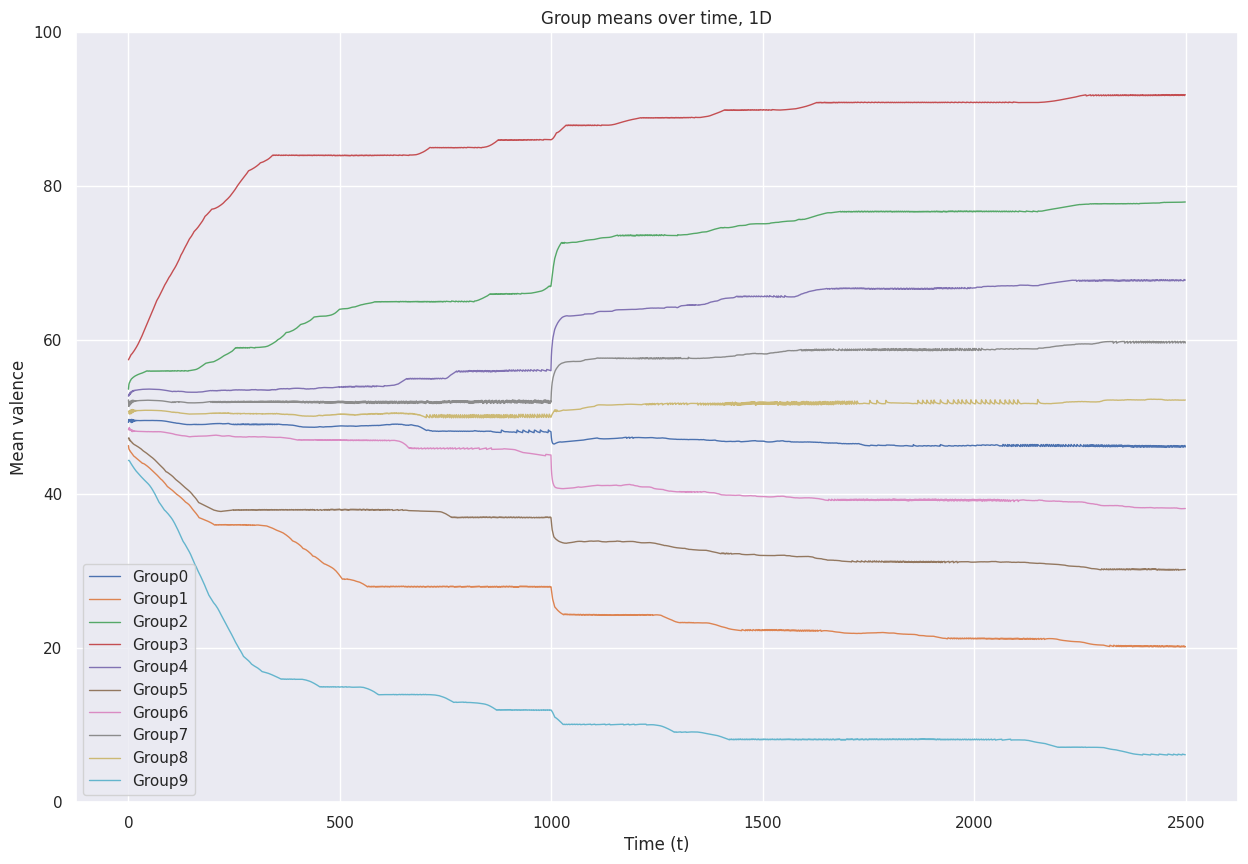

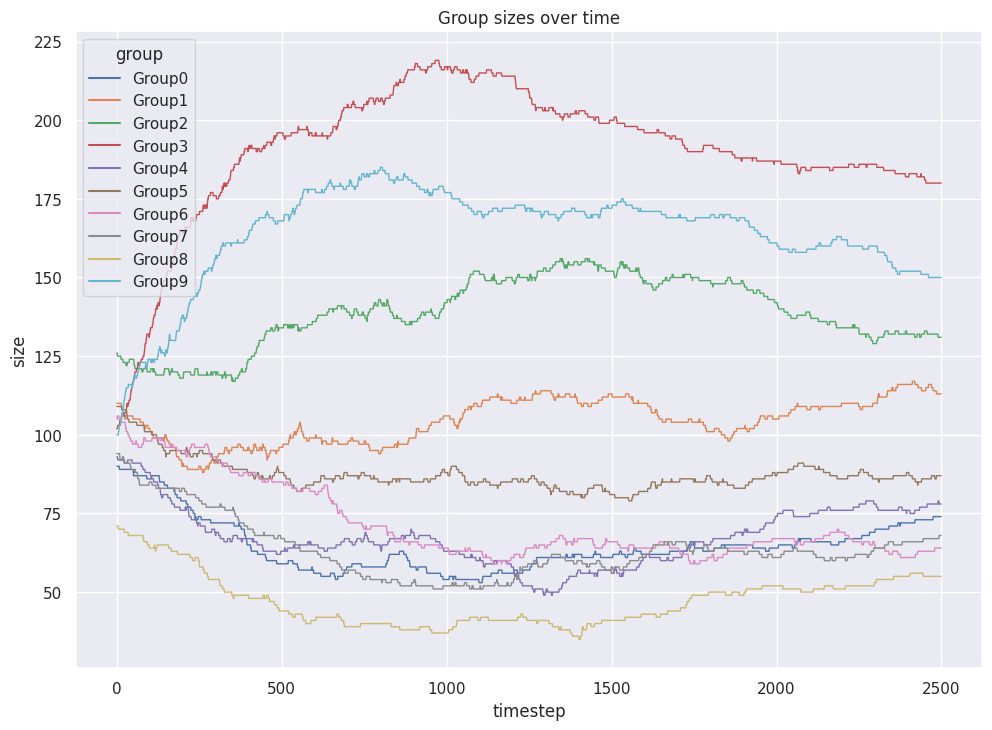

Plotting timespan from 0 to 2500...


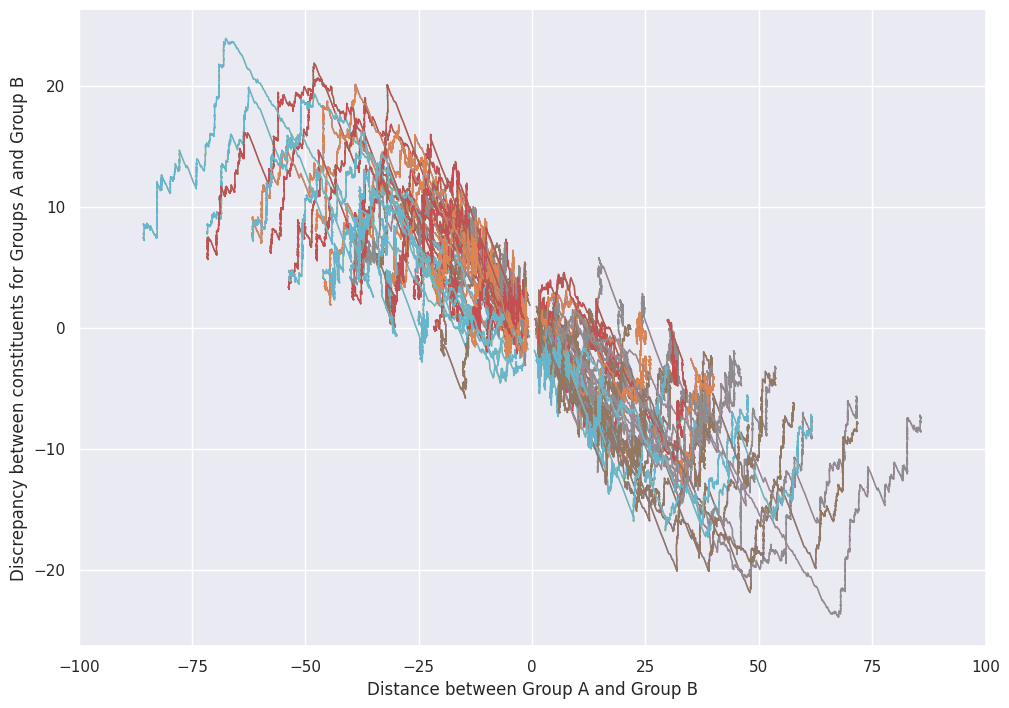

Plotting timespan from 0 to 2500...


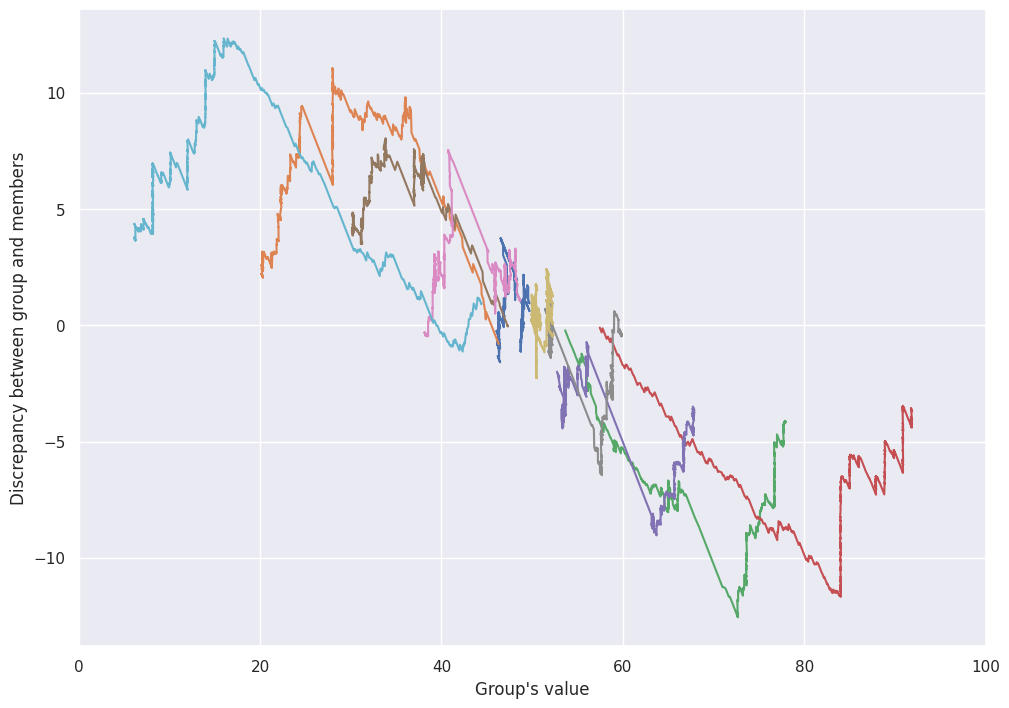

In [ ]:
testSim.plotTimelineMeans(legend=True)
testSim.plotTimelineSizes(legend=True)
plt.show()
#testSim.plotDistSwap(legend=False)
testSim.plotRMC(legend=True, timespan = [])#, scattersize = 20)
testSim.plotRMCsimple(legend=True, timespan = [])

Initial


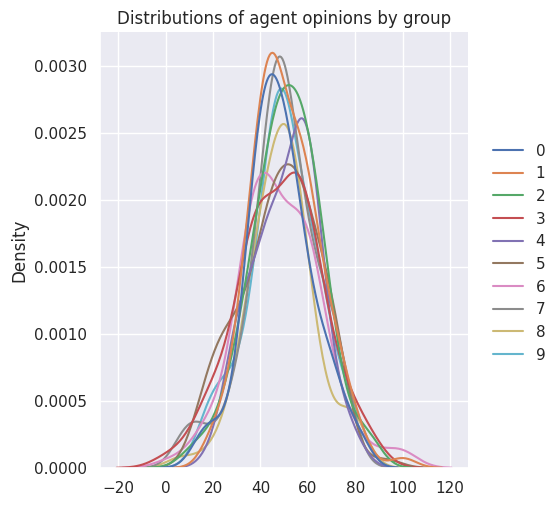

t=500


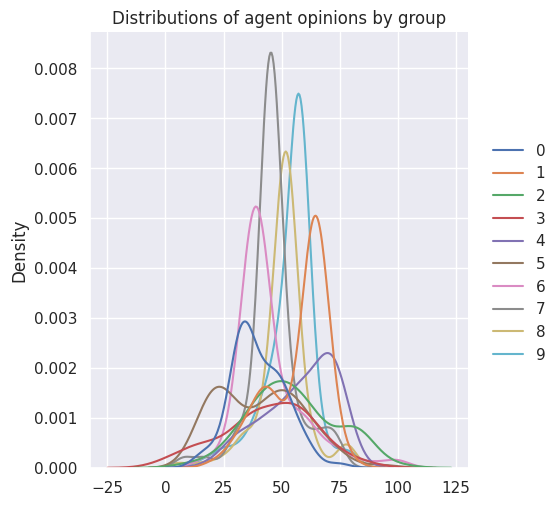

t=1000


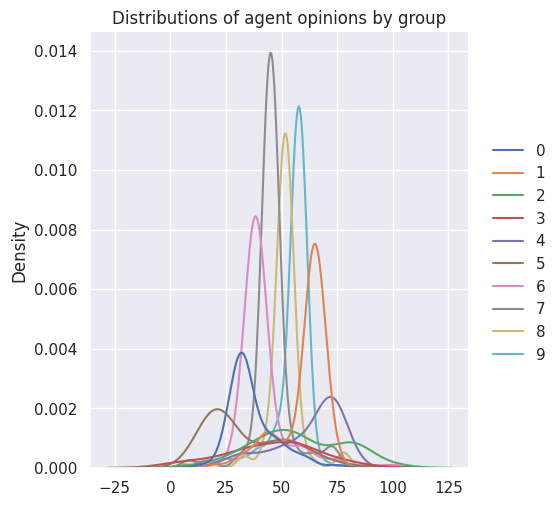

t=2000


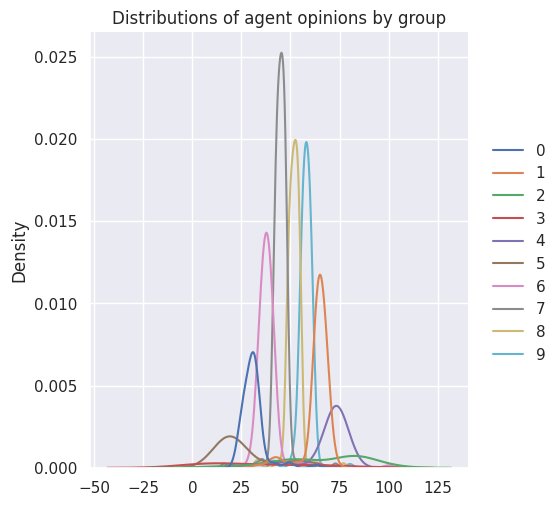

Final


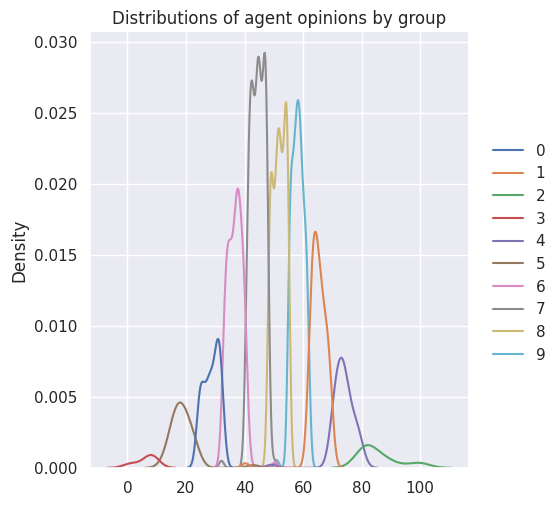

In [ ]:
print("Initial")
testSim.plotIndivDist(t = 0, overall = False)
plt.show()

print("t=500")
testSim.plotIndivDist(t = 500, overall = False)
plt.show()

print("t=1000")
testSim.plotIndivDist(t = 1000, overall = False)
plt.show()

print("t=2000")
testSim.plotIndivDist(t = 2000, overall = False)
plt.show()

print("Final")
testSim.plotIndivDist(t = 'now', overall = False)
plt.show()

Plotting timespan from 0 to 10000...


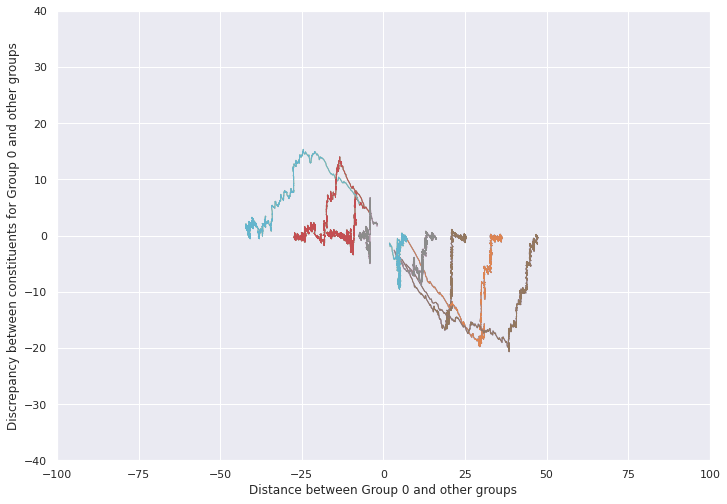

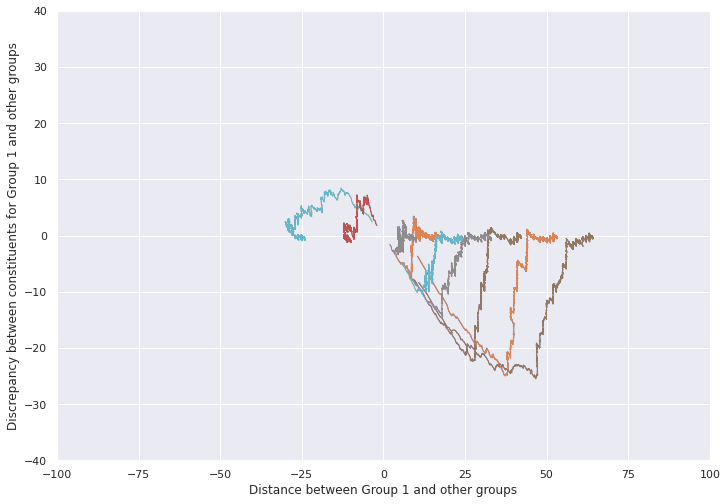

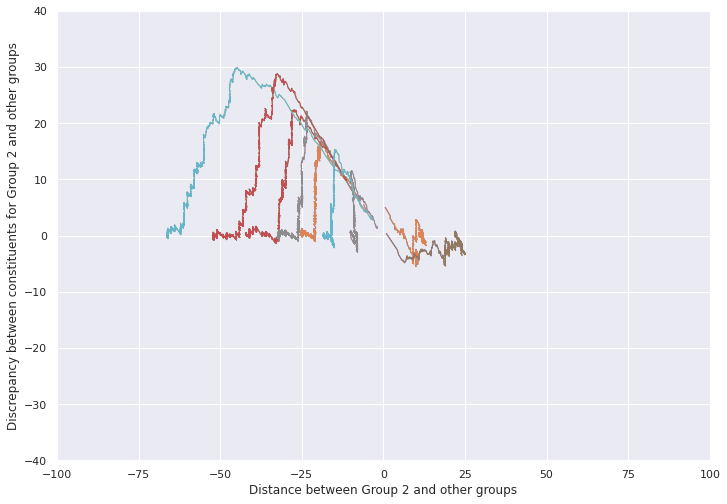

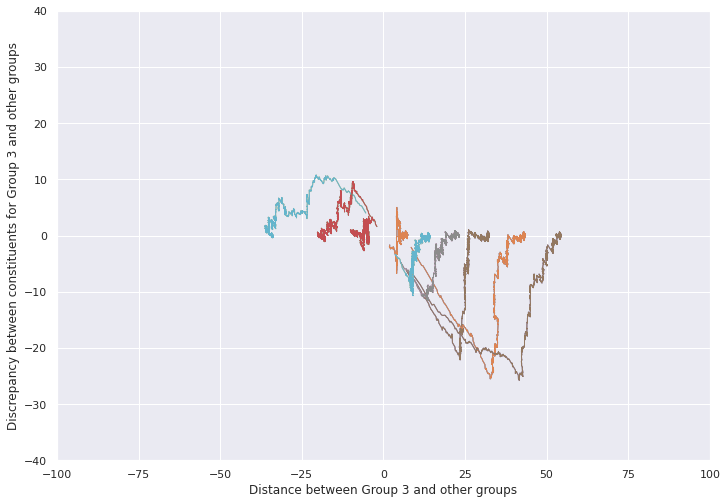

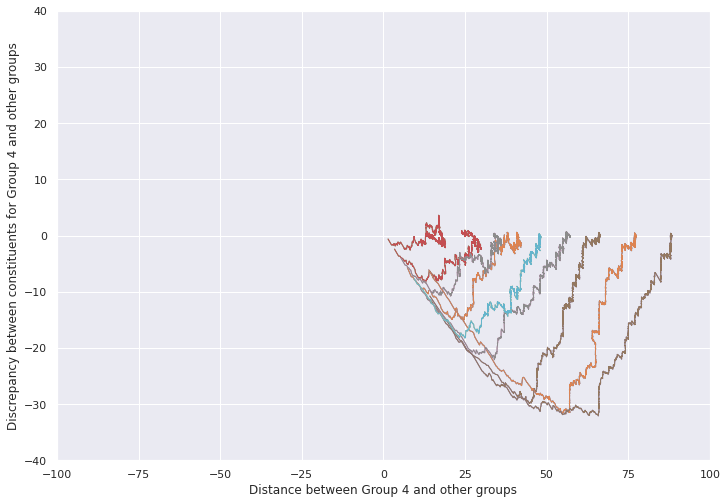

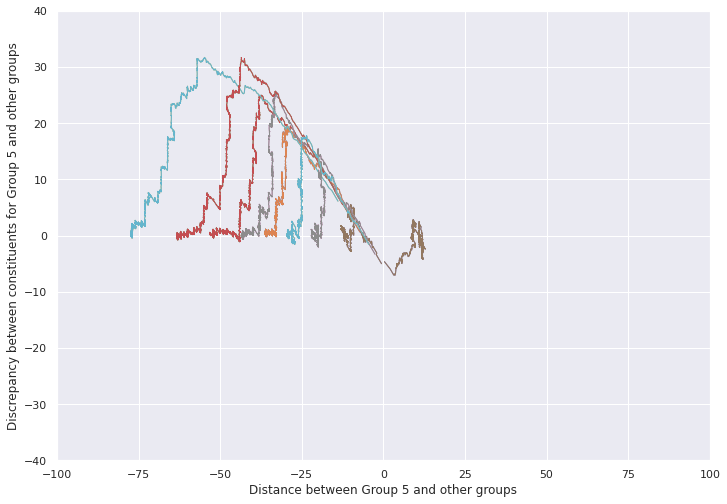

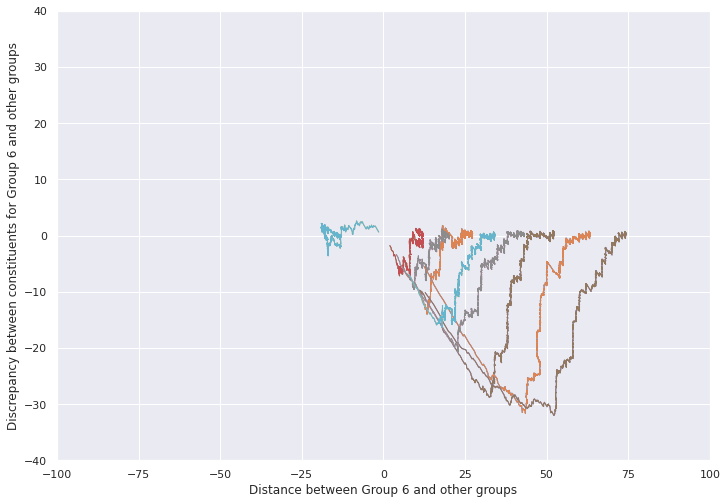

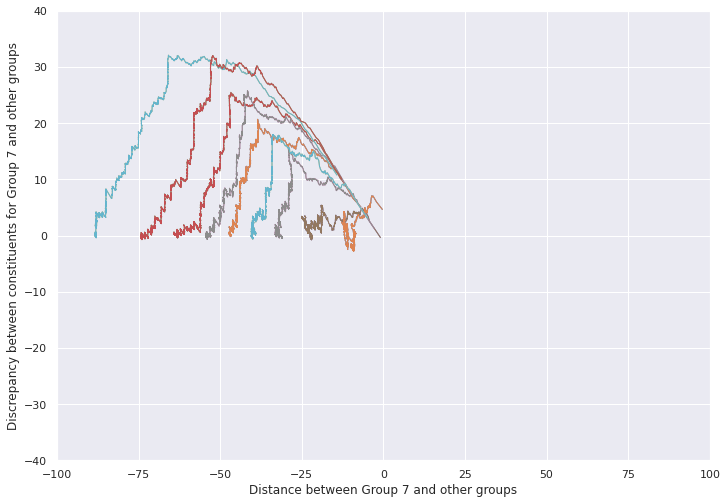

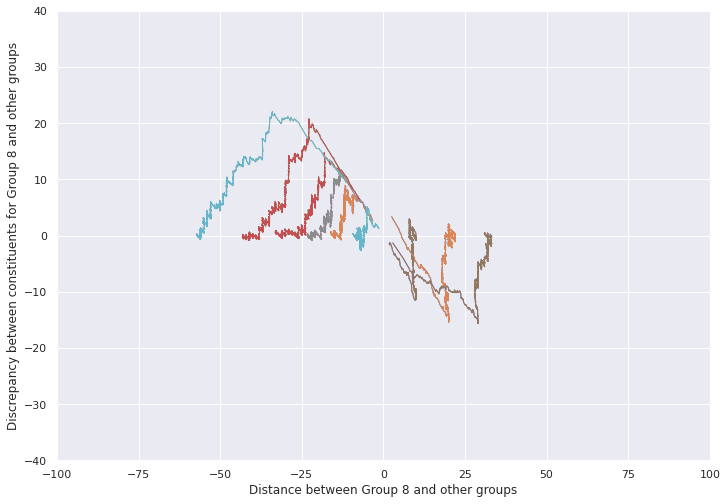

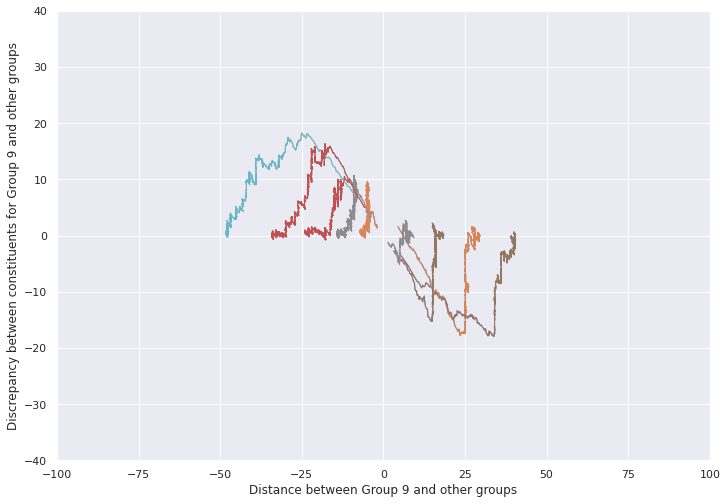

In [ ]:
testSim.plotRMC(legend=True, ylimits = [-40,40], timespan = [], individual_plots=True)
#Try and then specify other ylimits
#Individual_plots needs scattersize <--not going to fix this for now, 3/19/23

In [ ]:
asdf = list(np.linspace(1,100,num=timesteps))

group_function_parameters2 = {'rWidth': asdf,
                             'rAmp' : 1,
                             'aWidth' : 500, 
                             'aAmp' : 1}

testSim2 = GroupshiftSim(groupshift_function = groupshiftRepulseAttract,
                        indivchoice_function = oneNodeOpenSwitch, #default to doNothing
                        groupFargs = group_function_parameters2, 
                        save_timesteps=list(range(0,timesteps,100)))

In [ ]:
#Random, normal, or sorted
testSim2.initializeNodes(num_nodes, num_groups, 'random')
testSim2.runSimulation(timesteps)

100%|██████████| 2500/2500 [01:14<00:00, 33.70it/s]


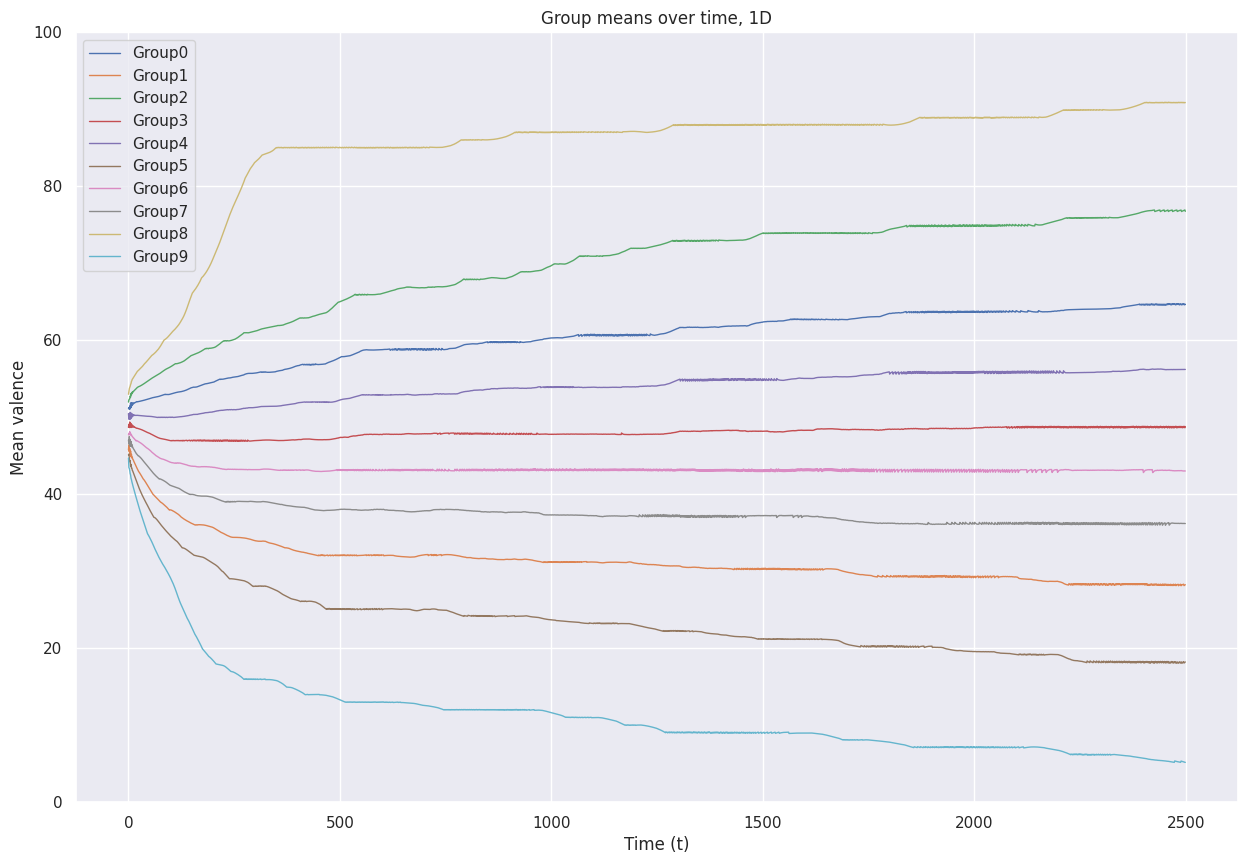

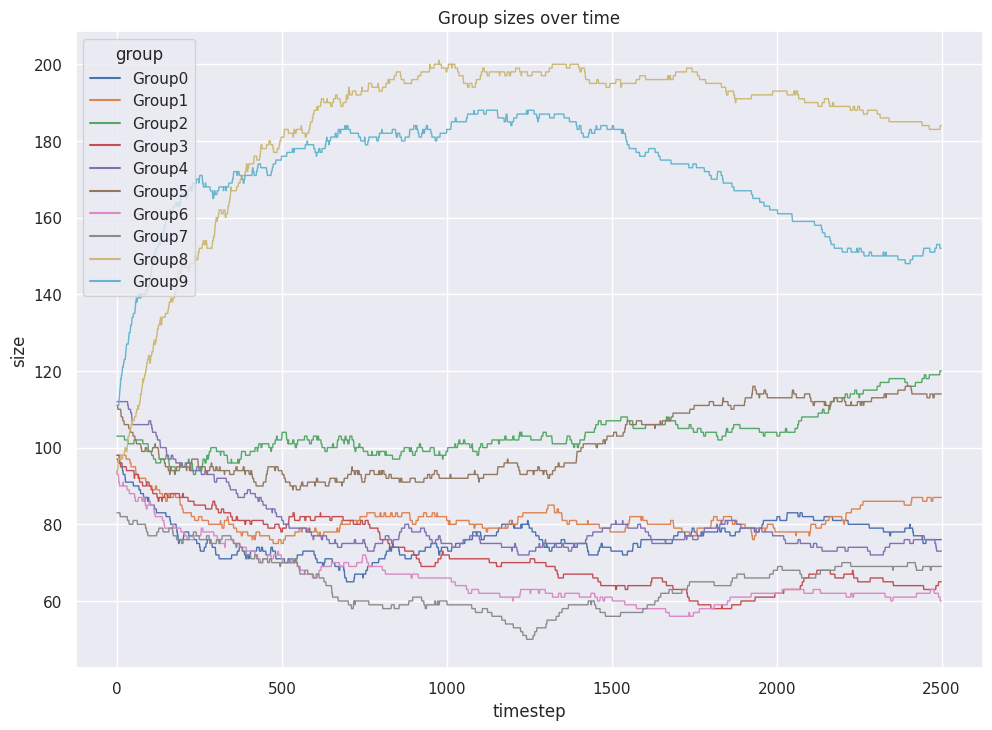

Plotting timespan from 0 to 2500...


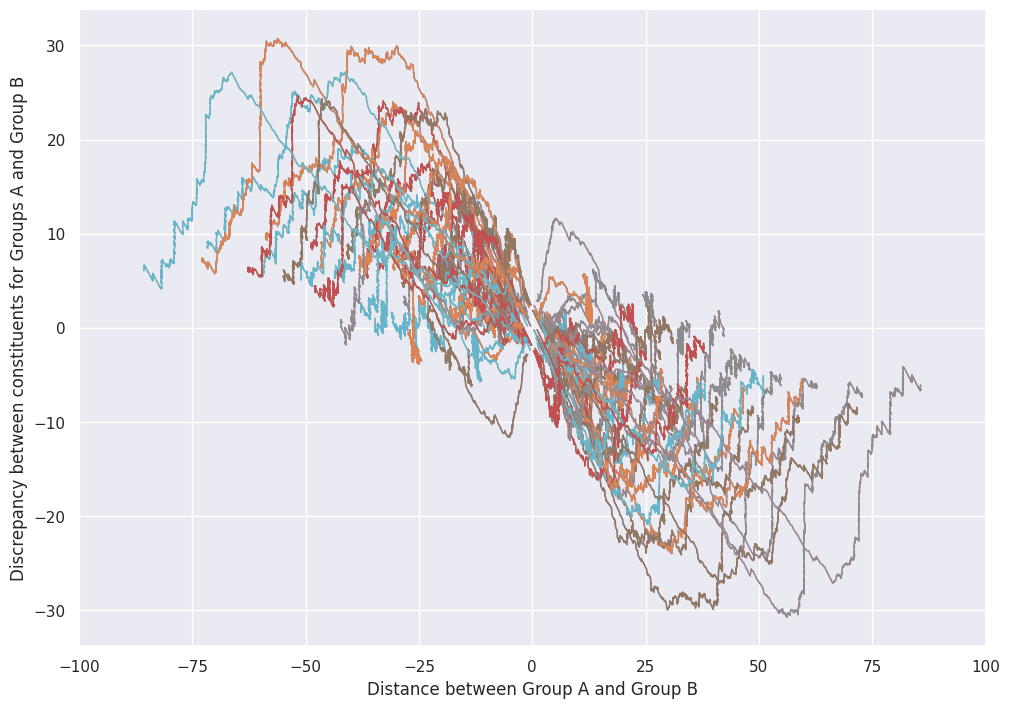

Plotting timespan from 0 to 2500...


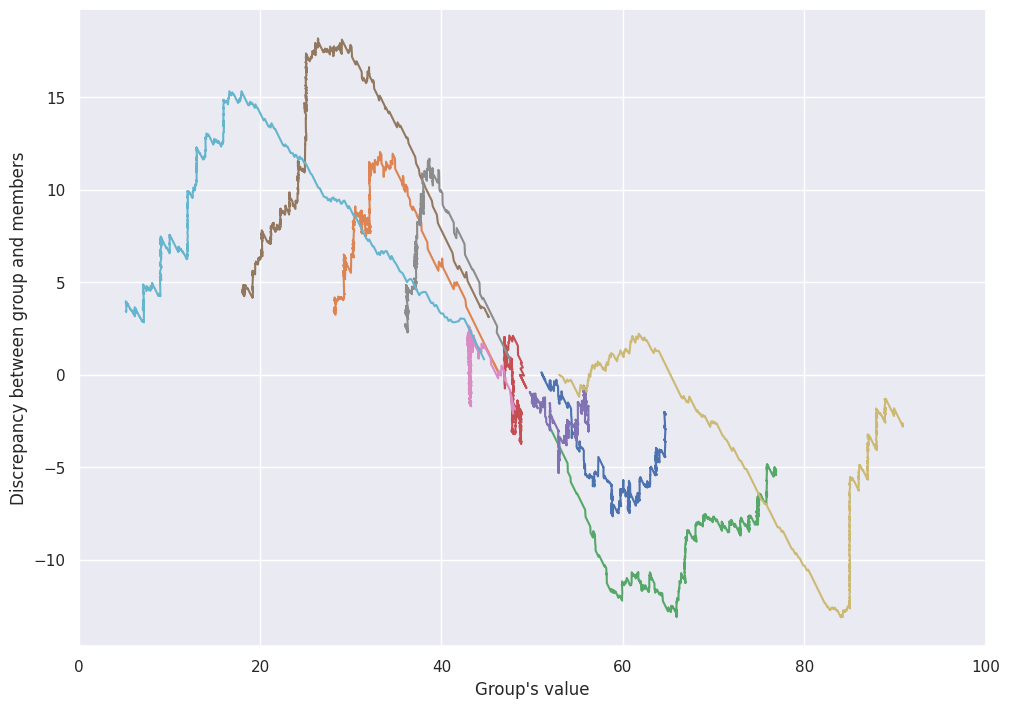

In [ ]:
testSim2.plotTimelineMeans(legend=True)
testSim2.plotTimelineSizes(legend=True)
plt.show()
#testSim.plotDistSwap(legend=False)
testSim2.plotRMC(legend=True, timespan = [])#, scattersize = 20)
testSim2.plotRMCsimple(legend=True, timespan = [])

## Model 11 Timelag in individual perceptions

In [5]:
testSim = GroupshiftSim(groupshift_function = groupshiftRepulseAttract,
                        indivchoice_function = oneNodeOpenSwitch, #default to doNothing
                        #groupFargs = group_function_parameters, 
                        save_timesteps=list(range(0,2500,100)))

testSim.initializeNodes(500, 5, 'random')

In [6]:
'perception' in testSim.g.nodes[0]

False

In [5]:
def nodeSwitchByPerception(self, public_info):
  #Randomly select a node
  thisnode = np.random.choice(self.nodelist)

  if 'perception' not in self.g.nodes[thisnode]:
    #Check if 'perception' is in any other node
    perception_in_only_some_nodes = []
    for node in self.g.nodes():
      if 'perception' in self.g.nodes[node]:
        perception_in_only_some_nodes.append = True
      else:
        perception_in_only_some_nodes.append = False

    if True in perception_in_only_some_nodes and False in perception_in_only_some_nodes:
      raise Exception("Issue checking and assigning initial perception values for individual nodes. For some reason, only some but not all nodes have been given a perception value.")        

    #Give every node in the network a perception value
    if True not in perception_in_only_some_nodes and False in perception_in_only_some_nodes:
      for i in self.nodelist:
        self.g.node[i]['perception'] = public_info #This should only happen once

  #Calculate distances (for colors)
  dists = {}
  for i in self.g.nodes[thisnode]['perception']:
    dists[i] = np.linalg.norm(self.g.nodes[thisnode]['perception'][i] - self.g.nodes[thisnode]['valence'])
  #Get the group with the minimum distance
  mingroup = min(dists,key=dists.get)
  #Replace current group edge
  currentgroup = list(self.g.neighbors(thisnode))[0]
  if currentgroup != mingroup:
    self.g.remove_edge(thisnode,currentgroup)
    self.g.add_edge(thisnode,mingroup)

  #Update the individual's perception of that group
  self.g.nodes[thisnode]['perception'][mingroup] = public_info[mingroup]
  

In [6]:
num_nodes = 100
num_groups = 3
timesteps = 500

asdf = np.linspace(1,100,num=timesteps)

group_function_parameters = {'rWidth': asdf,
                             'rAmp' : 1,
                             'aWidth' : 500, 
                             'aAmp' : 1}

testSim = GroupshiftSim(groupshift_function = groupshiftRepulseAttract,
                        indivchoice_function = nodeSwitchByPerception, 
                        groupFargs = group_function_parameters, 
                        save_timesteps=list(range(0,timesteps,100)))

In [7]:
#Random, normal, or sorted
testSim.initializeNodes(num_nodes, num_groups, 'random')
testSim.runSimulation(timesteps)

  0%|          | 0/500 [00:00<?, ?it/s]


ValueError: ignored

In [ ]:
testSim.plotTimelineMeans(legend=True)
testSim.plotTimelineSizes(legend=True)
plt.show()

#testSim.plotRMC(legend=True, timespan = [])#, scattersize = 20)
#testSim.plotRMCsimple(legend=True, timespan = [])

# Metrics to calculate

Hypotheses and theories:
* Hypothesis: Closer groups means more PI

Types of metrics:
* Proportion calculations: 
 * Proportion of people who are in suboptimal groups (in general)
 * Proportion of people who are in suboptimal groups that are adjacent to them
 * ^Not sure how to present these proportions since they overlap
* Within-group vs between-group similarity?
* Difference of individuals 

Iteratable variables:
* Proportion of num nodes to num groups (assuming large numbers)
* Width/amplitude of attraction and repulsion forces

Theoretical issues:
* This model is about network-structure (non-motivated?) causes for PI. It's closer to majority illusion (a network structure effect) than a psychological effect. 
* This model is an intergroup model. Does that mean PI isn't relevant?


Attempts:
* Plot [distance between group A and group B] vs [Proportion of people in Group A who would prefer to be in group B, and vice versa] 
 * Questions
   * Does this mean "Proportion of people in Group A whose optimal group is group B"? Or just prefer? No. Working on "better" for now
   * Corrections for ratio calculations? Doesn't seem necessary
   * Aggregation? Is it necessary?
* Plot the [proportion of people in A who would switch, but only the group's nearest neighbors in terms of mean]?
* Plot [ingroup variance] vs [betweengroup variance]? This would be missing the within-group pressure to switch?
* Track the number of groups whose theoretical constituent means and actual values cross each other? This might imply that the two groups should be pushing against each other

# Misc code pile

I don't remember what the following code was for:

In [ ]:
#Plot running average

binsize = 250
plt.figure(figsize=(15,10))

for group in grouplist:
  thisthing = np.array(meansdata[group]).T
  plt.plot(moving_average(thisthing[0], binsize), linewidth=3, label=group)

plt.title("Group means over time, 1D")
plt.xlabel("Time (t)")
plt.ylabel("Mean valence")
plt.ylim(0,255)
plt.legend()
plt.show()

Junk code from previous fruchterman reingold

In [ ]:
# attractive force
def f_a(d,k):
    return d*d/k

# repulsive force
def f_r(d,k):
    return k*k/d

def groupshiftRepulseAttract(self, resettype='sust', s=1):
  A = #adjacency matrix
  t = #Keep temperature low but constant

def groupshiftRepulseAttract(self, resettype='sust', s=1):
  group_dvs = np.zeros(len(self.grouplist))
  #Calculate dvs from group values
  for i, groupname in enumerate(self.grouplist):
    groupneighs = list(self.g.neighbors(groupname))
    #Populate the mean values if they don't already exist
    if 'mean' not in self.g.nodes[groupname]: 
      thismean = np.mean( np.vstack( [self.g.nodes[eachnode]['valence'] for eachnode in groupneighs] ), axis=0)
      self.g.nodes[groupname]['mean'] = thismean
      continue

    #Calculate the repulsive forces between groups
    # for othergroupname in self.grouplist: #Calculate the distance between each group
    #   if groupname!=j: 
    #     temp_dv_r = self.g.nodes[groupname]['mean'] - self.g.nodes[othergroupname]['mean'] #Remember, this is an s-dimensional vector
    #     delta = np.sqrt(np.sum(temp_dv_r**2)) #Calculate the distance squared
    #     if delta!=0:
    #       d = f_r(delta,k_g)/delta
    #       group_dvs[i] += temp_dv_r*d

    #Calculate attractive forces with constituents
    for j in groupneighs: 
      temp_dv_a = self.g.nodes[groupname]['mean'] - self.g.nodes[j]['valence']
      delta = np.sqrt(np.sum(temp_dv_a**2))
      if delta!=0: 
        d = f_a(delta,k_i)/delta
        group_dvs[i] += -temp_dv_a*d
    
  print(group_dvs)
  #Update the group valences
  for i,groupname in enumerate(self.grouplist): 
    self.g.nodes[groupname]['mean'] += group_dvs[i]

The following code was a basic implementation of the setup that Rob suggested for repulsion and attraction. 

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
a = 100
b = np.array(range(1,200))

newlist = []
amp = 1
width = 500

for i in b:
  point = 1 if i<a else -1
  asdf = np.abs(a-i)**2
  newval = a + amp * point * np.exp(-1*(1/width)*asdf)
  #Sigmoid function?
  #newval = a + amp * point * (1/(1+np.exp(-1*(1/width)*asdf)))
  newlist.append(newval)

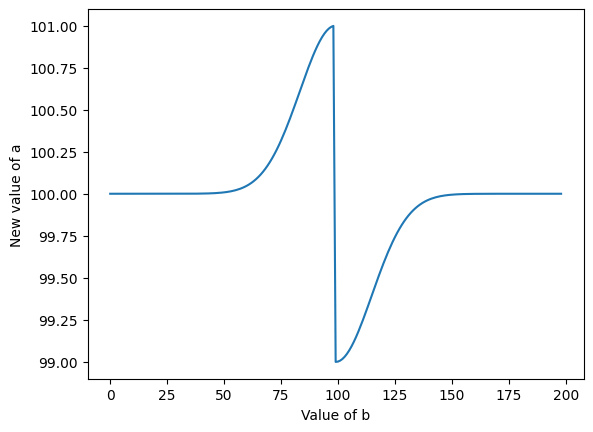

In [ ]:
plt.plot(newlist)
plt.xlabel("Value of b")
plt.ylabel("New value of a")
plt.show()

In [ ]:
a = [np.array([np.random.rand()]) for i in range(10)]
print(a)

d = distMatrix1D(a)

[array([0.57544352]), array([0.71511412]), array([0.38216625]), array([0.02574471]), array([0.14689826]), array([0.2232138]), array([0.6146809]), array([0.29023559]), array([0.81189034]), array([0.22398726])]


array([[0.        , 0.13967059, 0.19327728, ..., 0.28520794, 0.23644682,
        0.35145626],
       [0.13967059, 0.        , 0.33294787, ..., 0.42487853, 0.09677622,
        0.49112685],
       [0.19327728, 0.33294787, 0.        , ..., 0.09193066, 0.42972409,
        0.15817898],
       ...,
       [0.28520794, 0.42487853, 0.09193066, ..., 0.        , 0.52165475,
        0.06624832],
       [0.23644682, 0.09677622, 0.42972409, ..., 0.52165475, 0.        ,
        0.58790308],
       [0.35145626, 0.49112685, 0.15817898, ..., 0.06624832, 0.58790308,
        0.        ]])

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

y = []
t = 100
op = 7
neighbors = np.array([2,5,10,12,19])

amp = 1
width = 1

for i in range(t):
  for j in neighbors:
    point = 1 if op < j else -1
    asdf = np.abs(op-j)
    op += point * amp * np.exp(-1*(1/width)/asdf)
  y.append(op)

In [ ]:
print(np.mean(neighbors))
print(y[-1])

9.6
11.154095356215386


[8.29275370776584, 9.220350980967755, 9.935730309196435, 10.461893791094822, 10.80763184155332, 11.000087538369858, 11.090547354819012, 11.128698641619417, 11.144062431934815, 11.150148397085783, 11.152545049533288, 11.153486785275105, 11.15385651839057, 11.154001631261364, 11.154058577904355, 11.154080924358455, 11.154089693167283, 11.15409313404505, 11.154094484240309, 11.15409501405427, 11.154095221952131, 11.154095303530788, 11.15409533554207, 11.154095348103223, 11.154095353032192, 11.154095354966307, 11.154095355725248, 11.154095356023056, 11.154095356139917, 11.154095356185772, 11.154095356203765, 11.154095356210826, 11.154095356213597, 11.154095356214683, 11.154095356215109, 11.154095356215276, 11.154095356215343, 11.15409535621537, 11.15409535621538, 11.154095356215384, 11.154095356215386, 11.154095356215386, 11.154095356215386, 11.154095356215386, 11.154095356215386, 11.154095356215386, 11.154095356215386, 11.154095356215386, 11.154095356215386, 11.154095356215386, 11.1540953

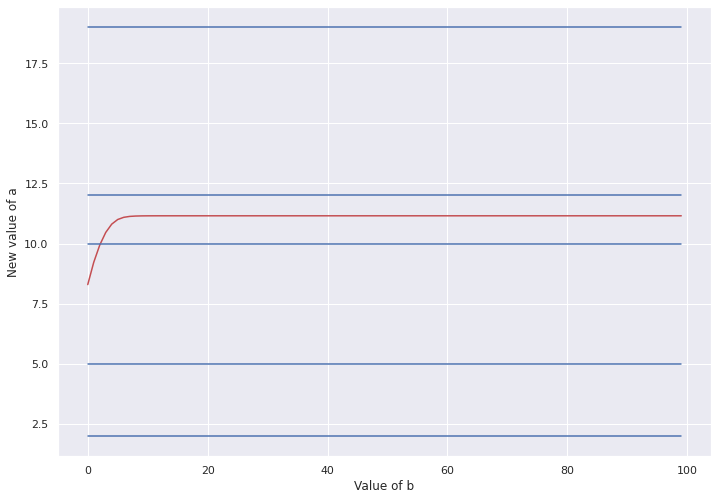

In [ ]:
print(y)
plt.plot(range(t),y,c='r')
for j in neighbors:
  plt.plot(range(t),[j]*t, c='b')
plt.xlabel("Value of b")
plt.ylabel("New value of a")
plt.show()